In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
import time
import torch.nn as nn

In [ ]:
N = 4000
a_pos1 = torch.randn(N//4, 2) + torch.tensor([2.0, 2.0])
a_pos2 = torch.randn(N//4, 2) + torch.tensor([-2.0, 3.0])
a_neg = torch.randn(N//2, 2) + torch.tensor([-2.0, -10.0])
a = torch.cat([a_pos1, a_pos2, a_neg], dim=0)
y = torch.cat([torch.ones(N//2), torch.zeros(N//2)])

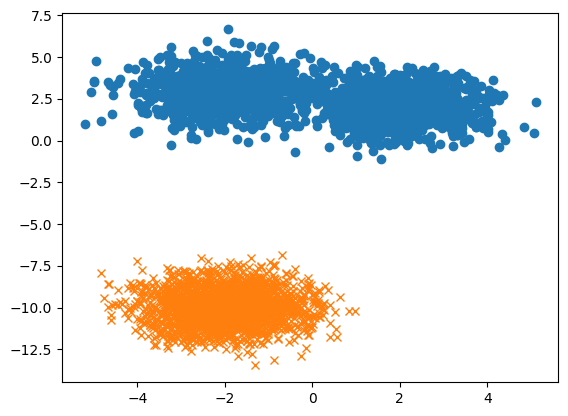

In [3]:
plt.plot(a[:N//2, 0], a[:N//2, 1], 'o', label='Positive')
plt.plot(a_neg[:, 0], a_neg[:, 1], 'x', label='Negative')
plt.show()

In [6]:
# cifar_classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
# from https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torchvision
import torchvision.transforms as transforms

# transform = transforms.Compose(
    # [transforms.ToTensor(),
    #  transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', 
                                      train=True,
                                      download=True, 
                                      #transform=transform
                                      )

testset = torchvision.datasets.MNIST(root='./data', 
                                     train=False,
                                     download=True,
                                     #transform=transform
                                     )

In [193]:
from torch.utils.data import TensorDataset

def filter_classes_MNIST(dataset, classes_to_keep):

    # Get data and targets
    data = dataset.data.flatten(start_dim=1)
    targets = dataset.targets

    # Create mask
    mask = (targets == classes_to_keep[0]) | (targets == classes_to_keep[1])

    # Apply mask
    filtered_data = (data[mask] / 255).float()

    label_map = {classes_to_keep[0]: 0, classes_to_keep[1]: 1}
    filtered_targets = torch.tensor([label_map[t.item()] for t in targets[mask]])

    return TensorDataset(filtered_data, filtered_targets)

In [194]:
mnist_01_train = filter_classes_MNIST(trainset, [0,1])
mnist_01_test = filter_classes_MNIST(testset, [0,1])

In [195]:
def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 2))
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.show()

In [196]:
# check https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/
# check https://github.com/shaoanlu/dogs-vs-cats-redux/blob/master/opt_experiment.ipynb

In [ ]:
from sklearn.datasets import make_blobs

# torch.manual_seed(42)
# np.random.seed(42)

DATASET_SIZE = 1000
DATASET_DIM = 20
DATASET_CLUSTER_COUNT = 5
DATASET_R = 20


clustered_data, _ = make_blobs(n_samples=DATASET_SIZE, 
                              n_features=DATASET_DIM,
                              centers=DATASET_CLUSTER_COUNT,
                              random_state=42)

clustered_data = torch.from_numpy(clustered_data.astype(np.float32))
full_labels = torch.zeros(DATASET_SIZE)

In [ ]:
from cluster_tools import kmeans_elbow, ClusterSampler, logistic_label_01_process

Samplers

In [7]:
from torch import nn

LAMBDA = 1e-4 # L2 regularization

class SimpleModel(nn.Module):
    def __init__(self, dataset):
        super().__init__()
        assert len(dataset.shape) == 2, "Do not use with images"
        dim = dataset.shape[1]
        self.layer = nn.Linear(dim, 1, bias=True)
        self.layer.weight.data.fill_(0)
        self.layer.bias.data.fill_(0)
    
    def forward(self, ai):
        return self.layer(ai)

def log_criterion(pred, labels):
    l = labels.view(-1, 1)
    return (nn.functional.softplus(-l*pred)).mean()

In [ ]:
clustered_data, full_labels = a, y
dataset = TensorDataset(clustered_data, full_labels)
labeled_data = logistic_label_01_process(dataset)

In [ ]:
# clustered_data, full_labels = mnist_01_train.tensors

In [12]:
clustered_data = (clustered_data - clustered_data.mean()) / np.sqrt(clustered_data.var())

In [ ]:
# labeled_data = logistic_label_01_process(mnist_01_train)

In [13]:
# probably utils function
from utils import dimension_reduction

compressed_data = dimension_reduction(clustered_data, alg="tsne")

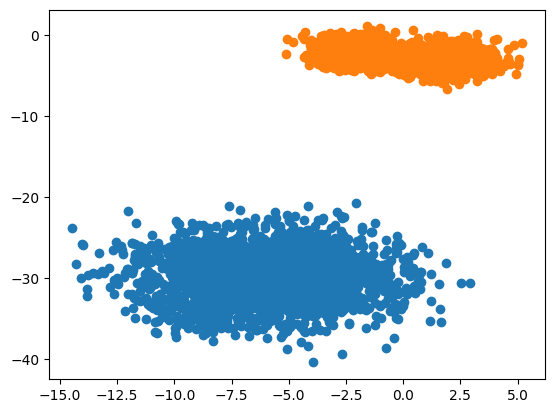

In [ ]:
compressed_labeled = dimension_reduction(labeled_data, alg="pca")
mask_0 = (full_labels == 0)
mask_1 = (full_labels == 1)
plt.scatter(compressed_labeled[mask_0,0], compressed_labeled[mask_0,1])
plt.scatter(compressed_labeled[mask_1,0], compressed_labeled[mask_1,1])

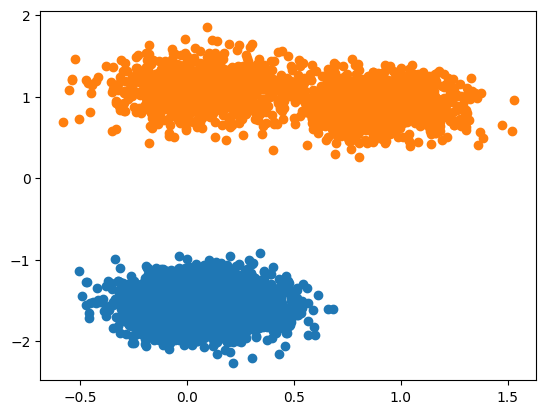

In [ ]:
cluster_sampler = ClusterSampler(dataset, 64, label_processing=logistic_label_01_process)
for i in range(cluster_sampler.cluster_count):
    selected = clustered_data[cluster_sampler.clusters[i]]
    plt.scatter(selected[:,0], selected[:,1])
# plt.scatter(compressed_data[mask_0,0], compressed_data[mask_0,1], color="white", alpha=0.1)
plt.show()

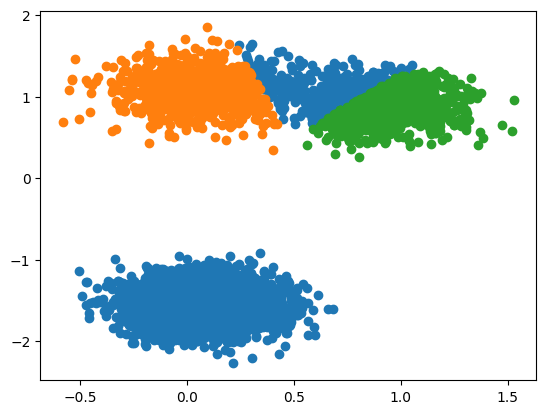

In [ ]:
from cluster_tools import kmeans_cos_elbow

cosine_cluster_sampler = ClusterSampler(dataset, 64, clustering_method=kmeans_cos_elbow, label_processing=logistic_label_01_process)
for i in range(cosine_cluster_sampler.cluster_count):
    selected = clustered_data[cosine_cluster_sampler.clusters[i]]
    plt.scatter(selected[:,0], selected[:,1])
# plt.scatter(compressed_data[mask_0,0], compressed_data[mask_0,1], color="white", alpha=0.1)
plt.show()

Solvers

In [17]:
def get_grad(batch, labels, model):
    ret = np.zeros_like(batch)
    for i, (elem, lab) in enumerate(zip(batch, labels)):
        res = model(elem)
        l = log_criterion(res, lab)
        model.zero_grad()
        l.backward()
        ret[i] = (next(model.parameters()).grad.data.detach().numpy().squeeze())
    return ret

In [51]:
# finding an exact solution

from tqdm import tqdm

model = SimpleModel(clustered_data)

curr_epoch = 0
losses = []
lr = 2

while 1:
    model.zero_grad()
    output = model(clustered_data)
    loss = log_criterion(output, full_labels)
    loss.backward()
    for p in model.parameters():
        p.data.sub_(lr*(p.grad.data + LAMBDA*p.data))
    losses.append(loss.item())
    curr_epoch += 1
    if curr_epoch % 1000 == 0:
        print(curr_epoch, loss.item())
    if curr_epoch > 1 and losses[-2] - losses[-1] < 1e-11:
        break

opt_val = losses[-1]
print(curr_epoch, opt_val)

1000 0.0009578383178450167
2000 0.0004955264739692211
3000 0.000445440731709823
4000 0.0004422851779963821
5000 0.0004381169565021992
6000 0.00043281802209094167
7000 0.0004288665659260005
8000 0.0004264627059455961
9000 0.00042512433719821274
10000 0.00042440486140549183
11000 0.00042403367115184665
11667 0.0004238800029270351


In [ ]:
output = model(clustered_data)
model.zero_grad()
loss = log_criterion(output, full_labels)
loss.backward()
for p in model.parameters():
    print(lr*(p.grad.data + LAMBDA*p.data))

tensor([[ 2.7857e-06, -7.1421e-07]])
tensor([-1.1855e-06])


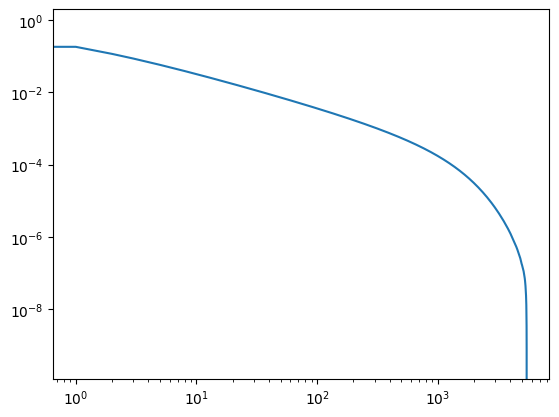

In [22]:
plt.plot(np.array(losses)-opt_val)
# plt.yscale("log")
plt.loglog()
plt.show()

In [28]:
from solvers import solve_problem, svrg, COVER, clusterSVRG

In [29]:
from utils import clone_model

In [30]:
NB_EPOCH = 100
TIME_LIM = None # 25
BATCH_SIZE = 8

REPEAT_TIMES = 1

In [31]:
base_model = SimpleModel(clustered_data)
lr = 2
lr_one_t = lambda epoch: 5 / (epoch+1)
# lr_log_t = lambda epoch: 5 * np.log(epoch+1) / (epoch+1)

In [32]:
cluster_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=cluster_sampler)
cosine_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=cosine_cluster_sampler)

iid_sampler = RandomSampler(dataset, replacement=True)
iid_dataloader = DataLoader(dataset, BATCH_SIZE, sampler=iid_sampler)

In [62]:
svrg_time, svrg_sol, _ = svrg(clone_model(base_model, clustered_data),
                regress_criterion,
                DataLoader(dataset, BATCH_SIZE, shuffle=True),
                clustered_data,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM,
                learning_rate=lr,
                lr_lambda=lr_log_t)

100%|██████████| 50/50 [00:01<00:00, 39.18it/s]


In [63]:
cover_time, cover_sol, _ = COVER(clone_model(base_model, clustered_data),
                     regress_criterion,
                     dataset,
                     RandomSampler(dataset),
                     clustered_data,
                     n_epoch=None,
                     time_lim=TIME_LIM,
                     learning_rate=lr,
                     lr_lambda=lr_log_t)

AssertionError: No limit to the number of iterations

In [ ]:
clusterSVRG_time, clusterSVRG_sol, _ = clusterSVRG(clone_model(base_model, clustered_data),
                     regress_criterion,
                     dataset,
                     RandomSampler(dataset),
                     clustered_data,
                     n_epoch=None,
                     time_lim=TIME_LIM,
                     learning_rate=lr,
                     lr_lambda=lr_log_t)

  0%|          | 3/100000 [00:34<320:36:28, 11.54s/it]


In [ ]:
grad_des_time, grad_des_sol, _ = solve_problem(
    clone_model(base_model, clustered_data), 
    regress_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=DataLoader(dataset, len(clustered_data)),
    n_epoch=NB_EPOCH,
    time_lim=TIME_LIM,
    verbose=True,
    lr=lr,
    # lr_lambda=lr_log_t,
    )

Building models...


  0%|          | 158/100000 [00:30<5:18:07,  5.23it/s]


In [ ]:
svrg_single_time, svrg_single_sol, _ = svrg(clone_model(base_model, clustered_data),
                regress_criterion,
                DataLoader(dataset, shuffle=True),
                clustered_data,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM,
                learning_rate=lr,
                lr_lambda=lr_log_t)

  0%|          | 3/100000 [00:39<363:39:27, 13.09s/it]


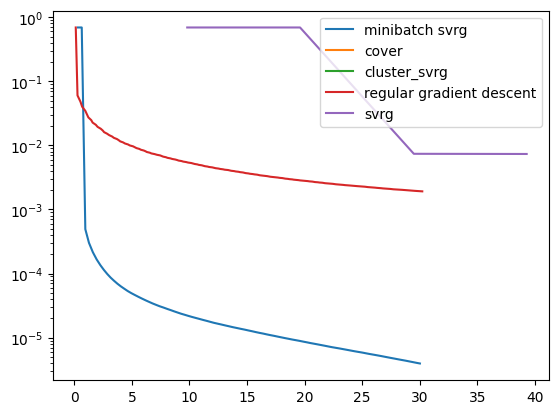

In [ ]:
plt.plot(svrg_time, svrg_sol-opt_val, label="minibatch svrg")
plt.plot(cover_time, cover_sol-opt_val, label="cover")
plt.plot(clusterSVRG_time, clusterSVRG_sol-opt_val, label="cluster_svrg")
plt.plot(grad_des_time, grad_des_sol-opt_val, label="regular gradient descent")
plt.plot(svrg_single_time, svrg_single_sol-opt_val, label="svrg")
plt.yscale("log")
plt.legend()
plt.show()

In [33]:
def repeat_exec(model,
                criterion,
                optimizer_class,
                dataloader,
                n_epoch=NB_EPOCH,
                time_lim=TIME_LIM,
                verbose=True,
                repeat_times=REPEAT_TIMES,
                lr=lr,
                lr_lambda=lr_one_t,
                l2=LAMBDA):
    timestamps, sols = [], []
    for i in range(repeat_times):
        sgd_time, sgd_sol, _ = solve_problem(model, 
                criterion,
                optimizer_class,
                dataloader,
                n_epoch,
                time_lim,
                verbose,
                lr,
                lr_lambda,
                l2)
        timestamps.append(sgd_time)
        sols.append(sgd_sol)
    return timestamps, sols

In [34]:
sgd_times, sgd_sols = repeat_exec(
    clone_model(base_model, clustered_data), 
    log_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=DataLoader(dataset, BATCH_SIZE, shuffle=True),
)

Building models...


100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


In [ ]:
adam_time, adam_sol, _ = solve_problem(clone_model(base_model, clustered_data), 
              regress_criterion,
              optimizer_class=torch.optim.Adam,
              dataloader=DataLoader(dataset, BATCH_SIZE, shuffle=True),
              n_epoch=NB_EPOCH,
              time_lim=TIME_LIM,
              verbose=True,
              lr=lr,
              lr_lambda=lr_log_t)

Building models...


  0%|          | 92/100000 [00:25<7:34:03,  3.67it/s]


In [ ]:
plt.plot(sgd_time, sgd_sol-opt_val, label="sgd")
plt.plot(adam_time, adam_sol-opt_val, label="adam")
plt.plot(svrg_time, svrg_sol-opt_val, label="svrg")
plt.plot(grad_des_time, grad_des_sol-opt_val, label="regular gradient descent")
plt.xlabel("time (s)")
plt.legend()
plt.yscale("log")
plt.show()

In [35]:
sgd_iid_times, sgd_sols_iid = repeat_exec(
    clone_model(base_model, clustered_data), 
    log_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=iid_dataloader,
)

Building models...


100%|██████████| 100/100 [00:24<00:00,  4.09it/s]


In [36]:
sgd_cluster_times, sgd_sols_cluster = repeat_exec(
    clone_model(base_model, clustered_data), 
    log_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=cluster_dataloader,
)

Building models...


100%|██████████| 100/100 [00:26<00:00,  3.79it/s]


In [37]:
sgd_cosine_times, sgd_sols_cosine = repeat_exec(
    clone_model(base_model, clustered_data), 
    log_criterion,
    optimizer_class=torch.optim.SGD,
    dataloader=cosine_dataloader,
)

Building models...


100%|██████████| 100/100 [00:27<00:00,  3.67it/s]


In [38]:
# from solvers import weighted_solver
# sgd_alt_cluster_t, sgd_alt_cluster, _ = weighted_solver(
#     clone_model(base_model, clustered_data), 
#     regress_criterion,
#     torch.optim.SGD,
#     dataset,
#     n_iter=None,
#     time_lim=TIME_LIM,
#     verbose=True
# )

In [ ]:
# plt.plot(sgd_iid_time, sgd_sol_iid-opt_val, label="iid replaced", alpha=0.8)
# plt.plot(sgd_cluster_time, sgd_sol_cluster-opt_val, label="clustered", alpha=0.8)
# plt.plot(sgd_cosine_time, sgd_sol_cosine-opt_val, label="cosine", alpha=0.8)
# plt.plot(sgd_time, sgd_sol-opt_val, label="successive", alpha=0.8)

# plt.legend()
# plt.yscale("log")
# plt.xlabel("time (s)")
# plt.title("using SGD with different sampling techniques")
# plt.show()

In [ ]:
# np.savetxt("./saves/sgd_iid_b8.txt", np.array(sgd_sols_iid))
# np.savetxt("./saves/sgd_clustered_b8.txt", np.array(sgd_sols_cluster))
# np.savetxt("./saves/sgd_cosine_b8.txt", np.array(sgd_sols_cosine))
# np.savetxt("./saves/sgd_b8.txt", np.array(sgd_sols))

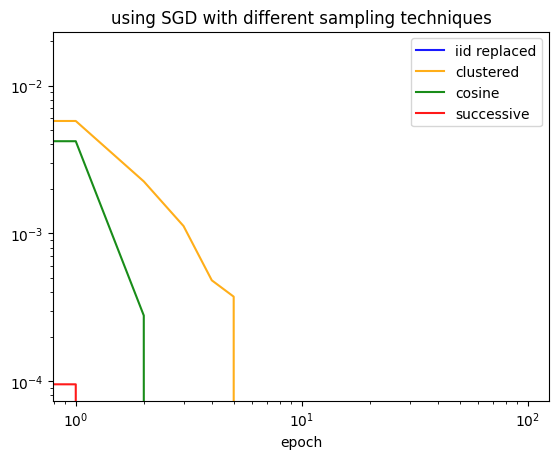

In [39]:
def plot_mult_iter(losses, opt_val, color, label):
    ls = np.array(losses)
    # for l in losses:
        # plt.plot(l-opt_val, alpha=0.1, color=color)
    m = np.mean(ls, axis=0)
    std = np.std(ls, axis=0)
    l = len(m)
    plt.plot(m-opt_val, color=color, label=label, alpha=0.9)
    plt.fill_between(np.arange(l), m-opt_val-std, m-opt_val+std, alpha=0.3)

plot_mult_iter(sgd_sols_iid, opt_val, color="blue", label="iid replaced")
plot_mult_iter(sgd_sols_cluster, opt_val, color="orange", label="clustered")
plot_mult_iter(sgd_sols_cosine, opt_val, color="green", label="cosine")
plot_mult_iter(sgd_sols, opt_val, color="red", label="successive")

plt.legend()
# plt.yscale("log")
plt.loglog()
plt.xlabel("epoch")
plt.title("using SGD with different sampling techniques")
plt.show()

In [75]:
from torch.optim.lr_scheduler import LambdaLR
from solvers import calc_grad

test_m = SimpleModel(clustered_data)
optimizer = torch.optim.SGD(test_m.parameters(), lr=lr, weight_decay=LAMBDA)
scheduler = LambdaLR(optimizer, lr_lambda=lr_one_t)

for i in range(3):
    for (batch, labels) in iid_dataloader:
        optimizer.zero_grad()
        loss = calc_grad(test_m, batch, labels, log_criterion)
        optimizer.step()

    outputs = test_m(iid_dataloader.dataset.tensors[0])
    epoch_loss = log_criterion(outputs, iid_dataloader.dataset.tensors[1])
    print(epoch_loss.item())

0.007293564733117819
0.0004690123605541885
0.00021851847122889012


In [72]:
opt_val

0.0004238800029270351

In [ ]:
model

In [225]:
from torch import Tensor

def display_grads(dataset:TensorDataset, model, cluster_sampler, alg="pca", title=""):
    dataset_torch, labels = dataset.tensors
    gradients = np.zeros_like(dataset_torch)
    lims = [0]
    for i in range(cluster_sampler.cluster_count):
        selected = dataset_torch[cluster_sampler.clusters[i]]
        selected_labels = labels[cluster_sampler.clusters[i]]
        grad_selected = get_grad(selected, selected_labels, model)
        # print(grad_selected)
        lims.append(lims[-1] + len(cluster_sampler.clusters[i]))
        gradients[lims[-2]:lims[-1], :] = grad_selected
    
    reduced = dimension_reduction(gradients, alg=alg)

    for i in range(cluster_sampler.cluster_count):
        plt.scatter(reduced[lims[i]:lims[i+1],0], reduced[lims[i]:lims[i+1],1], alpha=0.5)
    plt.title(title)
    plt.show()

In [226]:
cluster_dataloader.dataset

In [246]:
data, labels = cluster_dataloader.dataset.tensors
full_grad = np.mean(get_grad(data, labels, model), axis=0)
full_grad

array([0.00055746, 0.00023665], dtype=float32)

In [247]:
# checking the variance, see how much it's reduced...
def histogram(dataloader:DataLoader, full_grad=None, label=None):
    res = []

    if full_grad is None:
        data, labels = dataloader.dataset.tensors
        full_grad = np.mean(get_grad(data, labels, model), axis=0)

    print("calculating for {}".format(label))
    for (batch, labels) in dataloader:
        batch_grads = get_grad(batch, labels, model)
        res.append(np.sum((np.mean(batch_grads, axis=0) - full_grad)**2))
    return res[:-1]
    # plt.hist(res, density=True, label=label, alpha=1, histtype="step")
    # return np.array(res)
    
res_iid = histogram(iid_dataloader, full_grad, "iid"),
res_cluster = histogram(cluster_dataloader, full_grad, "cluster"),
res_cos = histogram(cosine_dataloader, full_grad, "cosine"),
res_successive = histogram(DataLoader(dataset, BATCH_SIZE), full_grad, "successive")
# plt.legend()
# plt.show()


calculating for iid
calculating for cluster
calculating for cosine
calculating for successive


0.003925171215087175
0.006942832376807928
0.005635620094835758


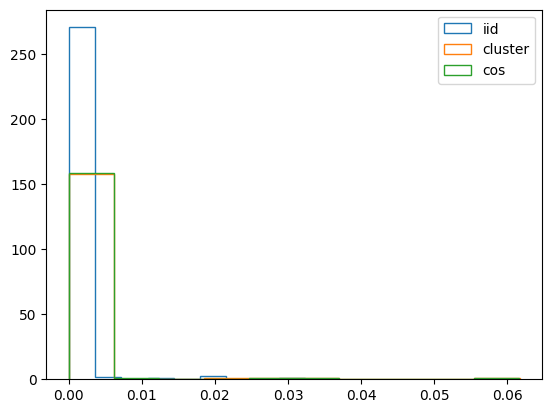

In [250]:
# zip(["iid","cluster", "cos", "successive"],
                    # [res_iid, res_cluster, res_cos, res_successive]):

for lab, res in zip(["iid","cluster", "cos"],
                    [res_iid, res_cluster, res_cos]):
    print(np.mean(res)*BATCH_SIZE)
    plt.hist(res, density=True, histtype="step", label=lab)
plt.legend()
plt.show()

In [ ]:
def plot_decision_boundary(data, model):
    w = model.layer.weight.detach().numpy().flatten()
    b = model.layer.bias.detach().item()
    x_vals = np.linspace(data[:,0].min(), data[:,0].max(), 100)
    if w[1] != 0:
        y_vals = -(w[0] * x_vals + b) / w[1]
        plt.plot(x_vals, y_vals, 'k--', label='Decision boundary (logit=0)')
    else:
        # vertical line if w[1] == 0
        x_const = -b / w[0]
        plt.axvline(x_const, linestyle='--', color='k', label='Decision boundary (logit=0)')

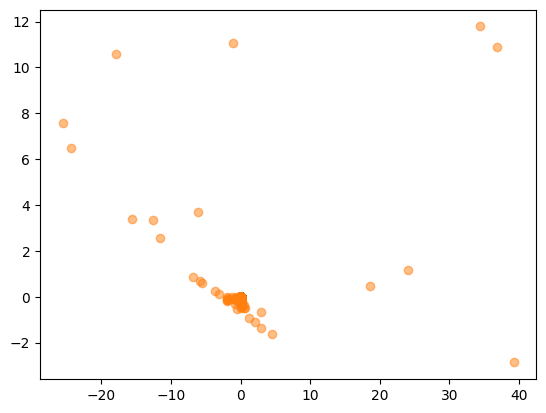

In [252]:
display_grads(dataset, model, cluster_sampler)